# Introduction to the accidents dataset
In this Notebook, you'll take your first look at the accidents dataset. We'll only be looking at the accidents for 2012, as that's all that will fit into the 32-bit MongoDB instance running on the virtual machine. 

This dataset contains details of every road traffic accident in Britain in 2012. The data is anonymised, but the date, time, and location of the accidents is recorded, along with the number and severity of casualties.

It will reinforce some of the ways of querying data with MongoDB and recap some ways of using *pandas* to analyse the data. 

In [2]:
# Import the required libraries

import pymongo
import datetime
import collections

import pandas as pd
import scipy.stats

In [3]:
# Open a connection to the Mongo server, open the accidents database and name the collections of accidents and labels
client = pymongo.MongoClient('mongodb://localhost:27351/')

db = client.accidents
accidents = db.accidents
labels = db.labels

In [105]:
# Load the expanded names of keys and human-readable codes into memory
# Don't bother reading this cell yet: we'll use it in a bit.

expanded_name = collections.defaultdict(str)
for e in labels.find({'expanded': {"$exists": True}}):
    expanded_name[e['label']] = e['expanded']
    
label_of = collections.defaultdict(str)
for l in labels.find({'codes': {"$exists": True}}):
    for c in l['codes']:
        try:
            label_of[l['label'], int(c)] = l['codes'][c]
        except ValueError: 
            label_of[l['label'], c] = l['codes'][c]

# A note on speed limits
The speed limit data in this dataset shows the speed limit of the road at the location of the accident. It says nothing about the speed of any particular vehicle, so you can't use this data to infer anything about whether speeding causes more accidents. However, it's reasonable to assume that vehicles will often be going faster in a 60mph zone than in a 30mph zone.

# Getting a single document
`find_one()` is the basic method for returning a single document from a collection. With no arguments, it just returns the first document it finds (chosen arbitrarily by Mongo).

In [5]:
accidents.find_one()

{'1st_Road_Class': 3,
 '1st_Road_Number': 308,
 '2nd_Road_Class': 5,
 '2nd_Road_Number': 0,
 'Accident_Index': '201201BS70001',
 'Accident_Severity': 3,
 'Carriageway_Hazards': 0,
 'Casualties': [{'Age_Band_of_Casualty': 7,
   'Bus_or_Coach_Passenger': 0,
   'Car_Passenger': 0,
   'Casualty_Class': 1,
   'Casualty_Home_Area_Type': 1,
   'Casualty_Reference': 1,
   'Casualty_Severity': 3,
   'Casualty_Type': 1,
   'Pedestrian_Location': 0,
   'Pedestrian_Movement': 0,
   'Pedestrian_Road_Maintenance_Worker': 0,
   'Sex_of_Casualty': 1,
   'Vehicle_Reference': 2}],
 'Date': '19/01/2012',
 'Datetime': datetime.datetime(2012, 1, 19, 20, 35),
 'Day_of_Week': 5,
 'Did_Police_Officer_Attend_Scene_of_Accident': 1,
 'Junction_Control': 2,
 'Junction_Detail': 6,
 'LSOA_of_Accident_Location': 'E01002821',
 'Latitude': 51.493429,
 'Light_Conditions': 4,
 'Local_Authority_(District)': 12,
 'Local_Authority_(Highway)': 'E09000020',
 'Location_Easting_OSGR': 527200,
 'Location_Northing_OSGR': 178760,

That's quite a bit of data, and it's not that useful to select an arbitrary accident report. Let's pull out an accident that happened in a 70 mph zone. We do that by giving a document that must match one in the database before it's returned.

In [6]:
accidents.find_one({'Speed_limit': 70})

{'1st_Road_Class': 3,
 '1st_Road_Number': 404,
 '2nd_Road_Class': -1,
 '2nd_Road_Number': 0,
 'Accident_Index': '201201CW10890',
 'Accident_Severity': 3,
 'Carriageway_Hazards': 0,
 'Casualties': [{'Age_Band_of_Casualty': 4,
   'Bus_or_Coach_Passenger': 0,
   'Car_Passenger': 0,
   'Casualty_Class': 1,
   'Casualty_Home_Area_Type': -1,
   'Casualty_Reference': 1,
   'Casualty_Severity': 3,
   'Casualty_Type': 9,
   'Pedestrian_Location': 0,
   'Pedestrian_Movement': 0,
   'Pedestrian_Road_Maintenance_Worker': 0,
   'Sex_of_Casualty': 1,
   'Vehicle_Reference': 1}],
 'Date': '06/07/2012',
 'Datetime': datetime.datetime(2012, 7, 6, 1, 25),
 'Day_of_Week': 6,
 'Did_Police_Officer_Attend_Scene_of_Accident': 1,
 'Junction_Control': -1,
 'Junction_Detail': 0,
 'LSOA_of_Accident_Location': 'E01004702',
 'Latitude': 51.519946,
 'Light_Conditions': 4,
 'Local_Authority_(District)': 1,
 'Local_Authority_(Highway)': 'E09000033',
 'Location_Easting_OSGR': 526780,
 'Location_Northing_OSGR': 181700,

If we give more than one key-value pair in the query document, the returned document must match all of them (an AND). For instance, to find an accident in a 30mph zone that involved two vehicles and one casualty, we specify that information in the query document:

In [7]:
accidents.find_one({'Speed_limit': 30, 'Number_of_Vehicles': 2, 'Number_of_Casualties': 1})

{'1st_Road_Class': 3,
 '1st_Road_Number': 308,
 '2nd_Road_Class': 5,
 '2nd_Road_Number': 0,
 'Accident_Index': '201201BS70001',
 'Accident_Severity': 3,
 'Carriageway_Hazards': 0,
 'Casualties': [{'Age_Band_of_Casualty': 7,
   'Bus_or_Coach_Passenger': 0,
   'Car_Passenger': 0,
   'Casualty_Class': 1,
   'Casualty_Home_Area_Type': 1,
   'Casualty_Reference': 1,
   'Casualty_Severity': 3,
   'Casualty_Type': 1,
   'Pedestrian_Location': 0,
   'Pedestrian_Movement': 0,
   'Pedestrian_Road_Maintenance_Worker': 0,
   'Sex_of_Casualty': 1,
   'Vehicle_Reference': 2}],
 'Date': '19/01/2012',
 'Datetime': datetime.datetime(2012, 1, 19, 20, 35),
 'Day_of_Week': 5,
 'Did_Police_Officer_Attend_Scene_of_Accident': 1,
 'Junction_Control': 2,
 'Junction_Detail': 6,
 'LSOA_of_Accident_Location': 'E01002821',
 'Latitude': 51.493429,
 'Light_Conditions': 4,
 'Local_Authority_(District)': 12,
 'Local_Authority_(Highway)': 'E09000020',
 'Location_Easting_OSGR': 527200,
 'Location_Northing_OSGR': 178760,

Recall that we can limit the key-value pairs returned by specifying the second argument to `find_one()`. 

This combines *selection* (the speed limit, one casualty, and two vehicles) and *projection* (only retrieving some parts of the document).

In [97]:
accidents.find_one({'Speed_limit': 30, 'Number_of_Casualties': 1, 'Number_of_Vehicles': 2}, 
                   ['Accident_Index', 'Speed_limit', 'Number_of_Casualties', 'Number_of_Vehicles'])

{'Accident_Index': '201201BS70001',
 'Number_of_Casualties': 1,
 'Number_of_Vehicles': 2,
 'Speed_limit': 30,
 '_id': ObjectId('52a9c97c92c4e16686d13265')}

# Finding multiple documents
If we want to find more than one document at a time, we use the imaginatively named `find()` function.

One useful thing the cursor can do is tell us how many documents match.

In [98]:
accidents.find({'Speed_limit': 30, 'Number_of_Casualties': 1, 'Number_of_Vehicles': 2}).count()

46715

With this dataset, the `limit` query keyword is extremely useful when exploring, as it stops us being overwhelmed by data. Let's create a small DataFrame to pick out a few attributes of a few accidents.

Recall that the output of `find()` is an iterator of `dict`s. If we convert the iterator to a `list`, we can create a DataFrame directly.

In [99]:
pd.DataFrame(list(accidents.find({'Speed_limit': 30, 'Number_of_Casualties': 1, 'Number_of_Vehicles': 2}, 
                                 ['Accident_Index', 'Accident_Severity', 'Road_Type','Weather_Conditions'],
                                 limit=10)))

,Accident_Index,Accident_Severity,Road_Type,Weather_Conditions,_id
0,201201BS70001,3,6,1,52a9c97c92c4e16686d13265
1,201201BS70002,3,6,1,52a9c97c92c4e16686d13266
2,201201BS70003,3,2,1,52a9c97c92c4e16686d13267
3,201201BS70006,3,6,2,52a9c97c92c4e16686d1326a
4,201201BS70008,3,1,1,52a9c97c92c4e16686d1326c
5,201201BS70010,3,2,1,52a9c97c92c4e16686d1326d
6,201201BS70011,3,6,2,52a9c97c92c4e16686d1326e
7,201201BS70014,3,3,1,52a9c97c92c4e16686d13271
8,201201BS70018,3,6,2,52a9c97c92c4e16686d13275
9,201201BS70025,3,6,1,52a9c97c92c4e16686d1327c


### Activity 1
How many accidents were there at less than 30mph?

Create a DataFrame that holds the accident index, number of vehicles, and number of casualties for each accident, where the speed limit is less than 30mph. 

(You may find it useful to revise 'Query criteria' in _MongoDB: The Definitive Guide_.)

The solution is in the [`14.2solutions`](14.2solutions.ipynb) Notebook.

In [100]:
#Insert your solution here
pd.DataFrame(list(accidents.find({'Speed_limit': {'$lt':30}},['Accident_Index', 'Number_of_Vehicles', 'Number_of_Casualties'])))

,Accident_Index,Number_of_Casualties,Number_of_Vehicles,_id
0,201297KC02607,1,1,52a9c98492c4e16686d36229
1,201201CP00031,1,1,52a9c97c92c4e16686d134e3
2,201201CP00067,3,1,52a9c97c92c4e16686d13506
3,201201CW10226,1,2,52a9c97c92c4e16686d13707
4,201201CW10270,2,2,52a9c97c92c4e16686d13724
5,201201CW10301,1,1,52a9c97c92c4e16686d13740
6,201201EK40242,1,2,52a9c97c92c4e16686d13cd6
7,201201EK40390,1,2,52a9c97c92c4e16686d13d56
8,201201EK40426,1,2,52a9c97c92c4e16686d13d77
9,201201EK40529,1,2,52a9c97c92c4e16686d13dd5


# Expanding the codes
A lot of the information in this dataset is recorded as codes rather than human-readable labels. The `labels` collection contains the labels for each code. 

Here are some examples for both looking up individual values and seeing what labels and codes there are. Treat these as recipes for your own explorations.

The `labels` collection contains the human-readable labels for all the codes in in the accident descriptions. We can ask for the labels and codes for `Road_Type`:

In [101]:
labels.find_one({'label': 'Road_Type'})

{'_id': ObjectId('52b0c65adbc24119018372a4'),
 'codes': {'-1': 'Data missing or out of range',
  '1': 'Roundabout',
  '12': 'One way street/Slip road',
  '2': 'One way street',
  '3': 'Dual carriageway',
  '6': 'Single carriageway',
  '7': 'Slip road',
  '9': 'Unknown'},
 'label': 'Road_Type'}

We can ask for the label of on particular type of road.

In [71]:
labels.find_one({'label': 'Road_Type'})['codes']['12']

'One way street/Slip road'

We can ask for all the labels:

In [102]:
road_types = []
road_code_labels = labels.find_one({'label': 'Road_Type'})['codes']
for code in road_code_labels:
    road_types.append(road_code_labels[code])
road_types

['Roundabout',
 'Unknown',
 'One way street',
 'Data missing or out of range',
 'Dual carriageway',
 'Slip road',
 'One way street/Slip road',
 'Single carriageway']

But, rather than doing lots of `append`s in a `for` loop, there's a more idiomatic Python approach: a _list comprehension_.

In [103]:
[road_code_labels[code] for code in road_code_labels]

['Roundabout',
 'Unknown',
 'One way street',
 'Data missing or out of range',
 'Dual carriageway',
 'Slip road',
 'One way street/Slip road',
 'Single carriageway']

To make things easier, the piece of code at the top of the notebook loads all the labels and codes into a `dict` called `label_of`. You can find the label of a code for a key by looking in there. The dict's keys are 2-tuples; the first element is the accident document's key we're looking up and the second is the code. The value is the human-readable label for that code. 

In [106]:
label_of[('Road_Type', 6)]

'Single carriageway'

Note that we dn't need the brackets around the 2-tuple when Python knows that's what we mean, which can make the code a little more readable.

In [72]:
label_of['Road_Type', 6]

'One way street/Slip road'

You can find all the codes and labels for a key by walking over the `dict`:

In [107]:
road_types = []
for (key, code) in label_of:
    if key == 'Road_Type':
        road_types.append(label_of[key, code])
road_types

['Unknown',
 'Roundabout',
 'One way street',
 'Single carriageway',
 'One way street/Slip road',
 'Dual carriageway',
 'Slip road',
 'Data missing or out of range']

or, more idiomatically, with a list comprehension. Note how the important parts of the cell above, the `for` and `if`, are still in the comprehension form.

In [108]:
[label_of[key, code] 
 for (key, code) in label_of 
 if key == 'Road_Type']

['Unknown',
 'Roundabout',
 'One way street',
 'Single carriageway',
 'One way street/Slip road',
 'Dual carriageway',
 'Slip road',
 'Data missing or out of range']

You can return the code with the label by wrapping them in a `tuple`. Again, note that we don't always need brackets aroun the tuple. The brackets are needed in the "return" position, but not in the `for` statement.

In [109]:
[(code, label_of[key, code]) 
 for key, code in label_of 
 if key == 'Road_Type']

[(9, 'Unknown'),
 (1, 'Roundabout'),
 (2, 'One way street'),
 (6, 'Single carriageway'),
 (12, 'One way street/Slip road'),
 (3, 'Dual carriageway'),
 (7, 'Slip road'),
 (-1, 'Data missing or out of range')]

### Activity 2
Find and display the document in the `labels` collection that stores details of weather conditions. 

Use the `label_of` dict to find all the labels for `Weather_Conditions`.

Use the `label_of` dict in a list comprehension to find all the labels for `Weather_Conditions` that refer to wind. Note that you can include more than one `if` clause in a list comprehension: just put them one after the other, like this:

    ```[item for item in thing if condition1 if condition2]```
    
It will only return items where both conditions are true.

The solution is in the [`14.2solutions`](14.2solutions.ipynb) Notebook.

In [117]:
# Insert your solution here
[label_of[key, code] for (key, code) in label_of 
 if (key == 'Weather_Conditions') and ('wind' in label_of[key, code])]


['Fine no high winds',
 'Raining no high winds',
 'Fine + high winds',
 'Snowing + high winds',
 'Snowing no high winds',
 'Raining + high winds']

Some keys in the documents are themselves cryptic, and the human-readable expanions of them are available in the `labels` collection. `expanded_name` dict gives their full names. You'll see these more in Part 15 when we look at the road census data.

In [51]:
# What does 'FdHGVR4' mean?
labels.find_one({'label': 'FdHGVR4'})

{'_id': ObjectId('52e953b6dbc2410efb5efe49'),
 'expanded': 'Rigid HGV with four axles',
 'label': 'FdHGVR4'}

The `expanded_name` dict also gives their full names. You'll see these more in Part 15 when we look at the road census data.

In [52]:
# What does 'FdHGVR4' mean?
expanded_name['FdHGVR4']

'Rigid HGV with four axles'

We can see which keys have labels for codes:

## Back to queries
Armed with this information, we can repeat the query earlier and list the accident indexes together with the human-readable data.

### Activity 3
The earlier query is below, but it prints the results rather than putting them in a DataFrame.

In [92]:
for a in accidents.find({'Speed_limit': 30, 'Number_of_Casualties': 1, 'Number_of_Vehicles': 2}, 
                                 ['Accident_Index', 'Accident_Severity', 'Road_Type','Weather_Conditions'],
                                 limit=10):
    print(a['Accident_Index'],  
          a['Accident_Severity'],
          a['Road_Type'], 
          a['Weather_Conditions'],
          a['_id'])

201201BS70001 3 6 1 52a9c97c92c4e16686d13265
201201BS70002 3 6 1 52a9c97c92c4e16686d13266
201201BS70003 3 2 1 52a9c97c92c4e16686d13267
201201BS70006 3 6 2 52a9c97c92c4e16686d1326a
201201BS70008 3 1 1 52a9c97c92c4e16686d1326c
201201BS70010 3 2 1 52a9c97c92c4e16686d1326d
201201BS70011 3 6 2 52a9c97c92c4e16686d1326e
201201BS70014 3 3 1 52a9c97c92c4e16686d13271
201201BS70018 3 6 2 52a9c97c92c4e16686d13275
201201BS70025 3 6 1 52a9c97c92c4e16686d1327c


Repeat this query, but print the labels of the accident severity, road type, and weather conditions (e.g. 
```
201201BS70001 Slight Single carriageway Fine no high winds
```
)

The solution is in the [`14.2solutions`](14.2solutions.ipynb) Notebook.

In [123]:
# Insert your solution here
for a in accidents.find({'Speed_limit': 30, 'Number_of_Casualties': 1, 'Number_of_Vehicles': 2}, 
                                 ['Accident_Index', 'Accident_Severity', 'Road_Type','Weather_Conditions'],
                                 limit=10):
        print(label_of['Accident_Index', a['Accident_Index']],  
          label_of['Accident_Severity',a['Accident_Severity']],
          label_of['Road_Type',a['Road_Type']], 
          label_of['Weather_Conditions',a['Weather_Conditions']],
          a['_id'])

 Slight Single carriageway Fine no high winds 52a9c97c92c4e16686d13265
 Slight Single carriageway Fine no high winds 52a9c97c92c4e16686d13266
 Slight One way street Fine no high winds 52a9c97c92c4e16686d13267
 Slight Single carriageway Raining no high winds 52a9c97c92c4e16686d1326a
 Slight Roundabout Fine no high winds 52a9c97c92c4e16686d1326c
 Slight One way street Fine no high winds 52a9c97c92c4e16686d1326d
 Slight Single carriageway Raining no high winds 52a9c97c92c4e16686d1326e
 Slight Dual carriageway Fine no high winds 52a9c97c92c4e16686d13271
 Slight Single carriageway Raining no high winds 52a9c97c92c4e16686d13275
 Slight Single carriageway Fine no high winds 52a9c97c92c4e16686d1327c


In this case, storing the looked-up values in the DataFrame is tricker, as we can't just use the dicts that come out of the `find()`. We have to do some processing and manually build a new dict for each document found.

In [124]:
pd.DataFrame([
        {'Accident_Index': a['Accident_Index'],
          'Accident_Severity': label_of['Accident_Severity', a['Accident_Severity']],
          'Road_Type': label_of['Road_Type', a['Road_Type']], 
          'Weather_Conditions': label_of['Weather_Conditions', a['Weather_Conditions']]}
        for a in accidents.find({'Speed_limit': 30, 
                                 'Number_of_Casualties': 1, 'Number_of_Vehicles': 2}, limit=10)])                  

,Accident_Index,Accident_Severity,Road_Type,Weather_Conditions
0,201201BS70001,Slight,Single carriageway,Fine no high winds
1,201201BS70002,Slight,Single carriageway,Fine no high winds
2,201201BS70003,Slight,One way street,Fine no high winds
3,201201BS70006,Slight,Single carriageway,Raining no high winds
4,201201BS70008,Slight,Roundabout,Fine no high winds
5,201201BS70010,Slight,One way street,Fine no high winds
6,201201BS70011,Slight,Single carriageway,Raining no high winds
7,201201BS70014,Slight,Dual carriageway,Fine no high winds
8,201201BS70018,Slight,Single carriageway,Raining no high winds
9,201201BS70025,Slight,Single carriageway,Fine no high winds


# Investigating the accident data
## Severities at one speed
We can now start to investigate the data. What are the proportions of accident severities in 30mph zones?

Note that the basic `find()` just returns documents: it can't do any aggregation and doesn't have anything like SQL's `GROUP BY` clause. In Part 15, we'll look at Mongo's aggregation pipelines, where we can get Mongo to do this kind of processing for us.

First, we'll collect the summary numbers ...

In [125]:
# Build a DataFrame, one row for each accident
severities_30_unrolled_df = pd.DataFrame(list(accidents.find({'Speed_limit': 30}, ['Accident_Severity'])))

# Count the number of each severity
severities_30_ss = severities_30_unrolled_df['Accident_Severity'].value_counts()
severities_30_ss

3    81727
2    12686
1      582
Name: Accident_Severity, dtype: int64

...and plot them.

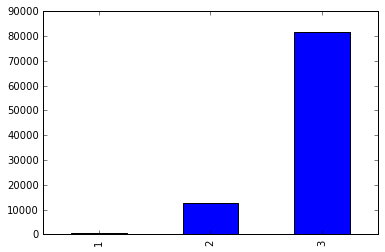

In [126]:
severities_30_ss.sort_index().plot(kind='bar')

...or, using the `label_of` dict to find the human-readable labels:

In [127]:
severities_30_ss.sort_index(inplace=True)
severities_30_ss.index = [label_of['Accident_Severity', r] for r in severities_30_ss.index]
severities_30_ss

Fatal        582
Serious    12686
Slight     81727
Name: Accident_Severity, dtype: int64

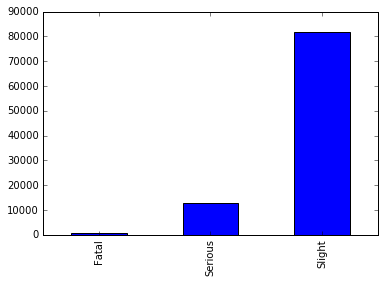

In [128]:
severities_30_ss.plot(kind='bar')

### Activity 4
What are the numbers of accidents at each severity in 60mph zones? Show your results as a bar chart.

The solution is in the [`14.2solutions`](14.2solutions.ipynb) Notebook.

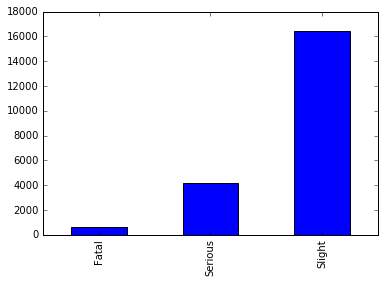

In [131]:
# Insert your solution here.
# Build a DataFrame, one row for each accident
severities_60_unrolled_df = pd.DataFrame(list(accidents.find({'Speed_limit': 60}, ['Accident_Severity'])))

# Count the number of each severity
severities_60_ss = severities_60_unrolled_df['Accident_Severity'].value_counts()
severities_60_ss

severities_60_ss.sort_index(inplace=True)
severities_60_ss.index = [label_of['Accident_Severity', r] for r in severities_60_ss.index]
severities_60_ss

severities_60_ss.plot(kind='bar')

## Severities across speeds
It's a bit tedious doing one speed at a time. Let's summarise all the data and put it in a *pandas* DataFrame so we can see it all together. 

Let's start by building a DataFrame with one row for each accident. We can then count the number of rows at each speed/severity combination with a _pandas_ `crosstab`. 

In [132]:
# Build a DataFrame, one row for each accident
severity_by_speed_unrolled_df = pd.DataFrame(list(accidents.find({}, ['Speed_limit', 'Accident_Severity'])))

# Count the number of each severity
severity_by_speed_df = pd.crosstab(severity_by_speed_unrolled_df['Speed_limit'], 
                                   severity_by_speed_unrolled_df['Accident_Severity'])
severity_by_speed_df

Accident_Severity,1,2,3
Speed_limit,,,
10,0,0,1
20,9,333,1905
30,582,12686,81727
40,155,1798,9961
50,94,770,4356
60,599,4157,16416
70,198,1157,8667


We can make the DataFrame more informative by relabelling the columns.

In [133]:
# Relabel the columns
severity_by_speed_df.columns = [label_of['Accident_Severity', s] for s in severity_by_speed_df.columns]
severity_by_speed_df

,Fatal,Serious,Slight
Speed_limit,,,
10,0,0,1
20,9,333,1905
30,582,12686,81727
40,155,1798,9961
50,94,770,4356
60,599,4157,16416
70,198,1157,8667


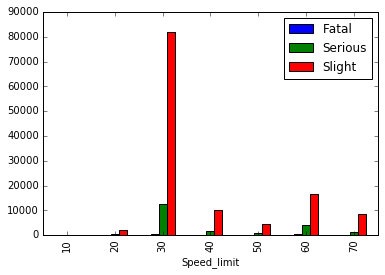

In [134]:
severity_by_speed_df.plot(kind='bar')

As an aside, it's sometimes useful to move the graph legend off to the side. Use this reformulation of the plotting to do so.

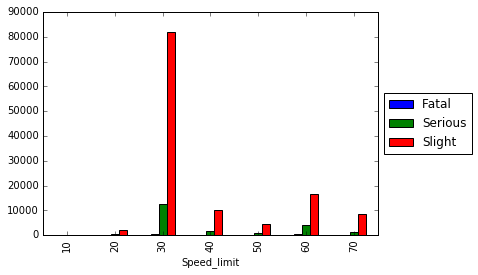

In [135]:
ax = severity_by_speed_df.plot(kind='bar')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

As you can see, there are a lot more accidents in 30mph zones than at any other speed limit. We'll have to account for that when we do some more detailed analysis later.

### Activity 5
What are the proportions of accident severities by junction type (roundabout, crossroads, etc)?

This is a more in-depth activity than before, so I've broken it down into steps.

* What are the different types of junction? You'll need to look at the `label_of` dict to find the right key
* What different severities happen at each junction type?

Comment on your results.

The solution is in the [`14.2solutions`](14.2solutions.ipynb) Notebook.

In [136]:
# Insert your solution here. 
# You will likely need several cells to complete this activity
list(accidents.find({}, ['Junction_Detail', 'Accident_Severity']))

[{'Accident_Severity': 3,
  'Junction_Detail': 6,
  '_id': ObjectId('52a9c97c92c4e16686d13265')},
 {'Accident_Severity': 3,
  'Junction_Detail': 3,
  '_id': ObjectId('52a9c97c92c4e16686d13268')},
 {'Accident_Severity': 3,
  'Junction_Detail': 3,
  '_id': ObjectId('52a9c97c92c4e16686d13266')},
 {'Accident_Severity': 3,
  'Junction_Detail': 6,
  '_id': ObjectId('52a9c97c92c4e16686d13267')},
 {'Accident_Severity': 3,
  'Junction_Detail': 3,
  '_id': ObjectId('52a9c97c92c4e16686d13269')},
 {'Accident_Severity': 3,
  'Junction_Detail': 6,
  '_id': ObjectId('52a9c97c92c4e16686d1326a')},
 {'Accident_Severity': 3,
  'Junction_Detail': 3,
  '_id': ObjectId('52a9c97c92c4e16686d1326b')},
 {'Accident_Severity': 3,
  'Junction_Detail': 1,
  '_id': ObjectId('52a9c97c92c4e16686d1326c')},
 {'Accident_Severity': 3,
  'Junction_Detail': 3,
  '_id': ObjectId('52a9c97c92c4e16686d1326d')},
 {'Accident_Severity': 3,
  'Junction_Detail': 3,
  '_id': ObjectId('52a9c97c92c4e16686d1326e')},
 {'Accident_Severity

# Looking at subdocuments
Each `accident` document contains two lists of subdocuments: one for each casualty, and one for each vehicle involved in the accident. How can we analyse those subdocuments?

Let's look at the distribution of ages across all accidents, but restrict our investigation to just the area around Milton Keynes, the home of The Open University. 

Is there any metadata about the accidents that relates to Milton Keynes?

In [137]:
# All the labels that are to do with 'Milton'.
[(k, c, label_of[k, c]) for k, c in label_of if 'Milton' in label_of[k, c]]

[('Local_Authority_(Highway)', 'E06000042', 'Milton Keynes'),
 ('Local_Authority_(District)', 479, 'Milton Keynes')]

While the district authority looks like the one that would have most meaning for people, the "highway" district authority is the one used by the rest of UK government. 

The casualty and vehicle subdocuments are held in arrays/lists, as there are different numbers of them for each accidents. This means we need to iterate over the casualty list within each accident. 

One way to get to the ages is by explicit two-level iteration, building up a list of age bands.

In [140]:
age_bands_of_casualties_list = []
for a in accidents.find({'Local_Authority_(Highway)': 'E06000042'}):
    for c in a['Casualties']:
        age_bands_of_casualties_list += [c['Age_Band_of_Casualty']]

aboc_ss = pd.Series(age_bands_of_casualties_list)
aboc_ss.count(), aboc_ss.head(10)

(1060, 0    5
 1    8
 2    7
 3    5
 4    6
 5    6
 6    7
 7    7
 8    2
 9    9
 dtype: int64)

We can now use standard _pandas_ operations on the series, such as counting how many casualties there are in each age band.

In [141]:
age_bands_of_casualties_ss = aboc_ss.value_counts()
age_bands_of_casualties_ss

 6     236
 7     183
 5     150
 8     135
 4     127
 9      71
 10     37
 3      37
 2      29
 11     24
 1      23
-1       8
dtype: int64

We can do the same thing with a comprehension, to avoid all the list appending. Note that there are two iterators in the comprehension, and they are in the same order as the nested `for` statements above.

In [142]:
aboc_ss = pd.Series(c['Age_Band_of_Casualty']
                    for a in accidents.find({'Local_Authority_(Highway)': 'E06000042'})
                    for c in a['Casualties'])

age_bands_of_casualties_ss = aboc_ss.value_counts()
age_bands_of_casualties_ss

 6     236
 7     183
 5     150
 8     135
 4     127
 9      71
 10     37
 3      37
 2      29
 11     24
 1      23
-1       8
dtype: int64

Finally, we can skip the intermediate `aboc` series by combining the Series creation and counting stages.

In [143]:
age_bands_of_casualties_ss = pd.Series(c['Age_Band_of_Casualty']
                    for a in accidents.find({'Local_Authority_(Highway)': 'E06000042'})
                    for c in a['Casualties']).value_counts()
age_bands_of_casualties_ss

 6     236
 7     183
 5     150
 8     135
 4     127
 9      71
 10     37
 3      37
 2      29
 11     24
 1      23
-1       8
dtype: int64

In [144]:
age_bands_of_casualties_ss.sort_index(inplace=True)
age_bands_of_casualties_ss

-1       8
 1      23
 2      29
 3      37
 4     127
 5     150
 6     236
 7     183
 8     135
 9      71
 10     37
 11     24
dtype: int64

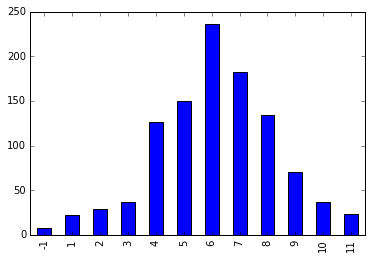

In [145]:
pd.Series(age_bands_of_casualties_ss).plot(kind='bar')

That's similar to what we'd expect, with fewer young and old casualties as there will be fewer of them on the road.

### Activity 6
We can also ask if different age people respond to injuries differently. In other words, are old people more frail and so therefore more likely to be seriously or fatally injured?

Following the examples above, let's build a DataFrame that counts the number of casualties for each age band / severity combination, and use the human-readable labels for the data rather than the codes.

You should end up with a `DataFrame` called `severity_by_age_df` that looks like this:


Severity | Fatal | Serious | Slight
-|-|-|-
Unknown | 0 | 0 | 8
0 - 5 | 0 | 3 | 20
6 - 10 | 0 | 1 | 28
11 - 15 | 0 | 3 | 34
16 - 20 | 1 | 11 | 115
21 - 25 | 1 | 16 | 133
26 - 35 | 2 | 15 | 219
36 - 45 | 3 | 12 | 168
46 - 55 | 0 | 10 | 125
56 - 65 | 1 | 7 | 63
66 - 75 | 0 | 9 | 28
Over 75 | 2 | 2 | 20

The solution is in the [`14.2solutions`](14.2solutions.ipynb) Notebook.

In [ ]:
# Insert your solution here.

Now you have the age data, can we plot it to see what it means?

In [ ]:
severity_by_age_df.plot()

The number of `slight` casualties is (thankfully) much larger than the other severities, so it's difficult to see if the proportions in different age bands remain similar. We can try plotting the data in separate graphs, mindful that the y-axis scales will be different in each graph. (It will show if there's a different pattern across severities.)

In [ ]:
severity_by_age_df.plot(subplots='True')

…or on one graph, using secondary y axis for non-slight casualties.

In [ ]:
severity_by_age_df['Slight'].plot()
severity_by_age_df['Serious'].plot(secondary_y=True)
severity_by_age_df['Fatal'].plot(secondary_y=True)

There doesn't seem to be a vast difference in the proportion of casualties. (The number of deaths is too low to draw any firm conclusions from.)

## Size of accidents: comparing numbers of vehicles and casualties
Some accidents are 'big' and some are 'small'. There are two obvious ways of describing such accidents: the number of casualties or the number of vehicles. We'd expect these two measures to be correlated. Let's find out if that's the case.

First, we'll read the sizes of accidents from the database and count them, as before

In [146]:
# Build a DataFrame, one row for each accident
cas_veh_unrolled_df = pd.DataFrame(list(accidents.find({}, ['Number_of_Casualties', 'Number_of_Vehicles'])))

# Count the number of each severity
cas_veh_df = pd.crosstab(cas_veh_unrolled_df['Number_of_Casualties'], 
                                      cas_veh_unrolled_df['Number_of_Vehicles'])
cas_veh_df

Number_of_Vehicles,1,2,3,4,5,6,7,8,9,10,11,12,13,16,18
Number_of_Casualties,,,,,,,,,,,,,,,
1,39217,65680,6168,1056,197,76,27,4,1,1,1,0,0,0,0
2,3781,15035,3002,716,128,41,14,4,6,3,0,1,0,1,0
3,682,4186,1203,319,73,25,12,6,2,0,1,0,0,0,0
4,287,1440,481,166,48,11,2,3,2,0,0,0,1,0,1
5,79,521,169,63,29,10,6,1,1,0,0,0,0,0,0
6,22,183,72,46,13,4,7,1,0,0,0,0,0,0,0
7,7,52,28,12,7,2,1,2,0,0,0,0,0,0,0
8,5,24,12,9,3,2,0,0,0,1,0,0,0,0,0
9,2,11,5,1,2,0,0,0,0,0,0,0,0,0,0


We want to plot this data as a scatter plot, but that function requires a sequences of casualty numbers, vehicle numbers, and counts of accidents for each pair. To convert this data into three sequences, we'll use the `stack()` and `reset_index()` methods you saw earlier.

In [147]:
cas_veh_long_df = cas_veh_df.stack().reset_index()
cas_veh_long_df

,Number_of_Casualties,Number_of_Vehicles,0
0,1,1,39217
1,1,2,65680
2,1,3,6168
3,1,4,1056
4,1,5,197
5,1,6,76
6,1,7,27
7,1,8,4
8,1,9,1
9,1,10,1


We can now plot the number of accidents at each casualty/vehicle combination on a *scatter chart*, a scatter plot that additionally uses the _size_ of each point to communicate information about a dimension of the data. In this case, we'll scale the point size by the number of accidents of that 'size'.

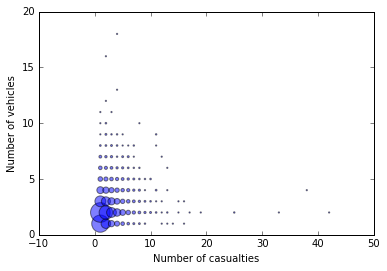

In [148]:
plt.scatter(cas_veh_long_df['Number_of_Casualties'], 
            cas_veh_long_df['Number_of_Vehicles'],
            s=np.sqrt(cas_veh_long_df[0])*1.5,
            alpha=0.5
            )
plt.xlabel('Number of casualties')
plt.ylabel('Number of vehicles')
plt.show()

There are a number of outliers, so let's remove them to see the rest of the points more easily. Limiting the data to 20 vehicles and 10 casualties looks reasonable.

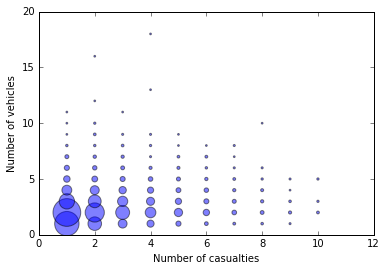

In [149]:
small_cvcl_df = cas_veh_long_df[(cas_veh_long_df['Number_of_Casualties'] <= 10) & 
                                (cas_veh_long_df['Number_of_Vehicles'] <= 20)]

plt.scatter(small_cvcl_df['Number_of_Casualties'], 
            small_cvcl_df['Number_of_Vehicles'],
            s=np.sqrt(small_cvcl_df[0])*3,
            alpha=0.5
            )
plt.xlabel('Number of casualties')
plt.ylabel('Number of vehicles')
plt.show()

Now we have some data plotted, can we say anything about the correlation of the two different metrics for 'size' of accident? From first impressions, there's not much correlation between the two measures: most of the accidents are small in both number of casualties and vehicles, and tend to be in the lower-left corner.

The obvious first step is to find the line of best fit, and then plot it.

Unfortunately, finding a regression line requires the data to be 'unrolled', with one row for each accident. The `cas_veh_unrolled_df` has this information, but we need to pull out the relevant columns.

In [150]:
cas_veh_unrolled_df.head()

,Number_of_Casualties,Number_of_Vehicles,_id
0,1,2,52a9c97c92c4e16686d13265
1,1,1,52a9c97c92c4e16686d13268
2,1,2,52a9c97c92c4e16686d13266
3,1,2,52a9c97c92c4e16686d13267
4,1,1,52a9c97c92c4e16686d13269


In [151]:
regressionline = scipy.stats.linregress(cas_veh_unrolled_df['Number_of_Casualties'],
                                       cas_veh_unrolled_df['Number_of_Vehicles'])
# The regression line is of the form y = m x + b
m = regressionline[0]
b = regressionline[1]
(m, b)

(0.21101011188488891, 1.542734939456031)

Now, plot the regression line on top of the scatter plot

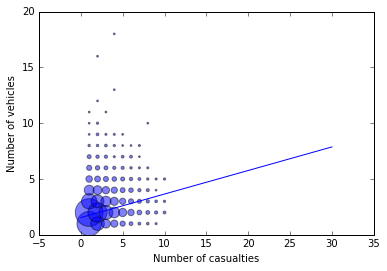

In [152]:
plt.scatter(small_cvcl_df['Number_of_Casualties'], 
            small_cvcl_df['Number_of_Vehicles'],
            s=np.sqrt(small_cvcl_df[0])*3,
            alpha=0.5
            )
plt.xlabel('Number of casualties')
plt.ylabel('Number of vehicles')

x = np.linspace(0, 30, 20)
plt.plot(x, m*x + b)

plt.show()

There is a line of best fit, but it doesn't seem to describe the data very well. In the next Notebook, we'll look at how to get a better handle on the this correlation.

### Activity 7

How does the number of vehicles in an accident vary with the speed limit?

Find the results, find the line of best fit, then plot the data and line of best fit on a scatter graph.

The solution is in the [`14.2solutions`](14.2solutions.ipynb) Notebook.

In [ ]:
# Insert your solution here.

## What next?
If you are working through this Notebook as part of an inline exercise, return to the module materials now.

If you are working through this set of Notebooks as a whole, move on to `14.3 Using statistical tests`.